In this notebook we'll construct a simple model of the visual system based on function spaces and use it for handwritten digit classification using the mnist dataset. To do this, we will make a hierarchy of function spaces and show how to connect them. Each level in the hierarchy is derived from the receptive fields of the corresponding brain region. In general, this provides a way of using the NEF when we only know the receptive field properties of cells, but can't analytically describe the transformations between populations. The transformations between function spaces are the way of specificying the connections, the training set only shows up as evaluation points.

The layers in this model consist of an 'photoreceptor' ensemble, a retinal center-surround layer, a V1 Gabor filter layer, and finally a classifier, as shown in the diagram below.

In [1]:
n_ret = 5000  # number of photoreceptor neurons
n_CS = 4000  # number of retinal center-surround (CS) cells
n_simple = 3000  # number of V1 simple cells
n_class = 500  # number of neurons in classifier ensemble
dim_CS = 300  # dimension of CS ensemble
dim_simple = 200  # dimension of V1 ensemble

<img src='vision.png'>

Advantages of this approach over traditional training are the following:

<ul>
<li> No training is neccessary - the NEF provides a mathematical way of setting connection weights, in contrast to training approaches which tend to be heuristic. </li>
<li> Only a fraction of training examples needed. </li>
<li> Since the function spaces are derived from the receptive fields of the brain region in question, if we set our receptive field parameters according to biological data the model would be closer to biology. </li>
<ul>

Load the mnist dataset, here we only use 10% of the training data (5000 images).

In [2]:
# load mnist dataset, but use a small subset for 'training'
n_train = 5000
from datasets import load_mnist
train_images, train_labels = load_mnist('train')
test_images, test_labels = load_mnist('test')

train_images = train_images[:n_train]
train_labels = train_labels[:n_train]

# normalize images
#train_image_norms = np.linalg.norm(train_images, axis=1)
#for i in range(len(train_images)):
#    train_images[i, :] = train_images[i] / train_image_norms[i]
#test_image_norms = np.linalg.norm(test_images, axis=1)
#for i in range(len(test_images)):
#    test_images[i, :] = test_images[i] / test_image_norms[i]

<h3> Center-Surround Cells </h3>

The following functions create the receptive fields of the retinal cells with center-on and center-off tuning as a difference of gaussians:

/home/youssef/.local/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/home/youssef/.local/lib/python2.7/site-packages/IPython/nbconvert.py:13: ShimWarning: The `IPython.nbconvert` package has been deprecated. You should import from ipython_nbconvert instead.
  "You should import from ipython_nbconvert instead.", ShimWarning)
/home/youssef/.local/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)
/home/youssef/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has m

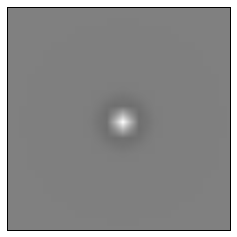

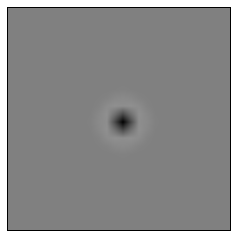

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from nengo.utils.function_space import uniform_cube, gen_args, gen_funcs, SVD_FS 
from nengo.dists import Uniform
from utils import plot_image, plot_images, real_gabor, imag_gabor, center_on, center_off

D = 28  # images are D x D
d = 2./D  # discretization of domain
 
points= uniform_cube(2, radius=1, d=d)
plot_image(center_on(points, center_x=0, center_y=0))
plot_image(center_off(points, center_x=0, center_y=0))

Make the CS function space:

In [4]:
n_basis = dim_CS

# arguments to sample center surround functions from
arg_dists = [Uniform(-1, 1), Uniform(-1, 1)]

domain_dim = 2
domain = uniform_cube(domain_dim=domain_dim, d=d)  # domain of the fns
args = gen_args(n_CS, *arg_dists)  # args for the fns
on = gen_funcs(center_on, args, domain)  #  make fns and evaluate on domain
off = gen_funcs(center_off, args, domain)
fns = np.vstack((on, off)) #  concatenate into one array

# function space utility in nengo, makes a bases from the given functions
CS = SVD_FS(fns=fns, domain_dim=2, n_basis=n_basis, d=2./D)

We plot the singular values below. This is a high dimensional space, as the receptive fields are small relative to the image.

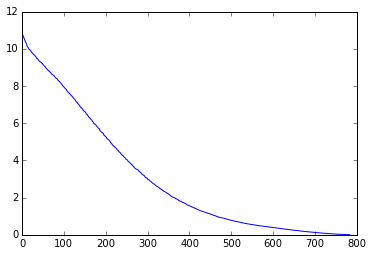

In [5]:
plt.plot(CS.singular_values())

Below is a plot of the basis images derived from the SVD. This is the space which the center surround ensemble will represent.

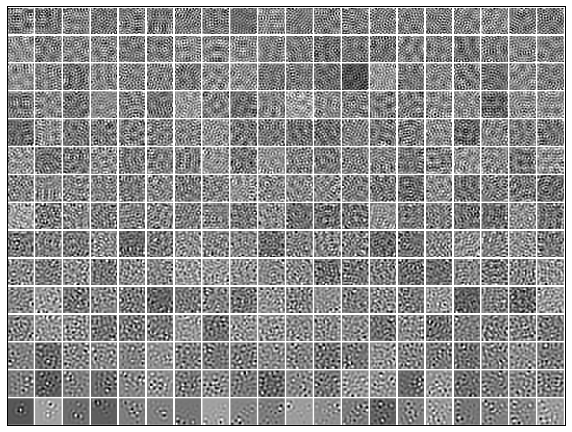

In [6]:
plot_images(CS.get_basis())

We can check how well an image is reconstructed back from its projection onto the function space. This shows how the function space 'sees' the image. This also varies with the number of basis functions used.

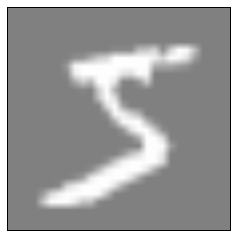

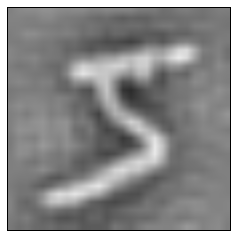

In [7]:
image = train_images[0] 
plot_image(image)
plot_image(CS.reconstruct(CS.project(image)))

<h3> Gabor Filters and V1 Simple Cells </h3>

Gabor filters have been shown to provide an accurate mathematical description of the receptive fields of simple cells and have applications in image analysis, computer vision, and modeling the primate visual system. 

The 2D Gabor filter is defined as the product of a plane wave with a Gaussian function, and has real and imaginary components. This is an example of a Gabor filter, with real and imaginary parts seperately. We will only use the real parts of the filters in what follows.

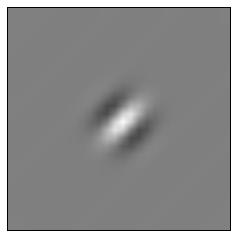

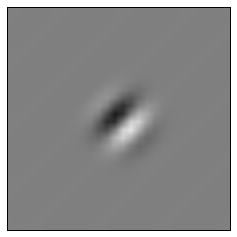

In [8]:
lambd = 0.4 # wave frequencey
theta = np.pi/4, # orientation
psi = 0 # phase
sigma = 0.15 # gaussian envelope size
gamma = 1 # ellipticity
    
points= uniform_cube(2, radius=1, d=2./D)
plot_image(real_gabor(points, psi=psi, gamma=gamma, sigma=sigma, lambd=lambd, theta=theta, x_offset=0, y_offset=0))
plot_image(imag_gabor(points, psi=psi, gamma=gamma, sigma=sigma, lambd=lambd, theta=theta, x_offset=0, y_offset=0))

The parameters of the Gabor functions that control the support of the function and the edge size will depend on the resolution we need for the images and must be tuned accordingly.

<h3> Gabor Function Space </h3>

In [9]:
n_basis = dim_simple

# arguments to sample gabors from
arg_dists = [Uniform(0, 2*np.pi), Uniform(0.4, 0.8), Uniform(0.2, 0.5), Uniform(0.3, 0.8), Uniform(0, 2*np.pi), Uniform(-1, 1), Uniform(-1, 1)]
# arg_dists = [Uniform(psi, psi), Uniform(2,4), Uniform(0.05, 0.35), Uniform(0.3, 0.7), Uniform(0, 2*np.pi), Uniform(-1, 1), Uniform(-1, 1)]

args = gen_args(n_simple, *arg_dists)  # args for the fns
gabors = gen_funcs(real_gabor, args, domain) 

# function space utility in nengo, performs the operations describe above
simple_FS = SVD_FS(fns=gabors, domain_dim=2, n_basis=n_basis, d=2./D)

Again we plot the singular values, the encoding functions, the basis, and see how well we can reconstruct images:

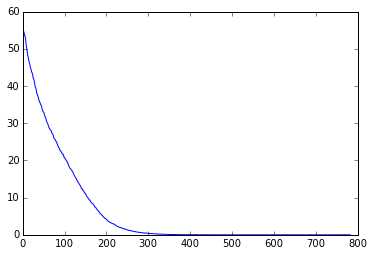

In [10]:
plt.plot(simple_FS.singular_values())

These are some of the encoder functions:

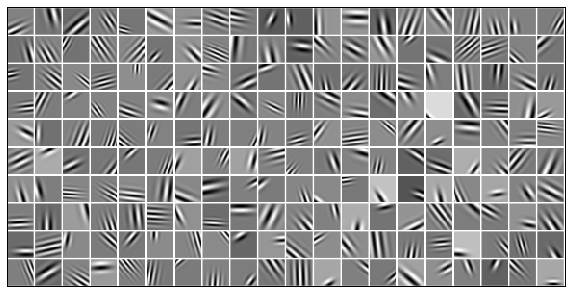

In [11]:
plot_images(simple_FS.fns[:200])

These are the orthonormal basis functions computed from the SVD:

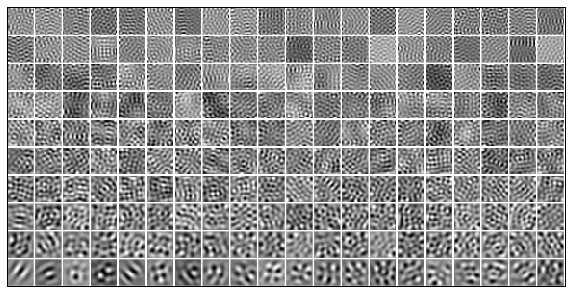

In [12]:
plot_images(simple_FS.get_basis())

And reconstruction:

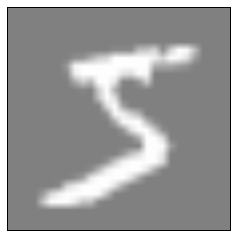

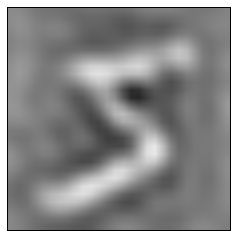

In [13]:
image = train_images[0] 
plot_image(image)
simple_FS.select_top_basis(100)
plot_image(simple_FS.reconstruct(simple_FS.project(image)))

<h3> Classifying Images </h3>

To perform classification, we create a 10D ensemble and define a classifier function that maps from the Gabor space ensemble to this classifier ensemble. This function must look at an image in function space and figures out its class. The 'training set' is specified through the evaluation points.

One way to define the classifier function is to reconstruct the image from the function space coefficients, then attempt to match the image to an mnist image in pixel space. However, image comparison in pixel space is not easy, and simple pixel-wise comparison is not very accurate. So let's do the comparisons in function space. 

In [14]:
# represent training images in function space
mnist_FS = simple_FS.project(train_images)

from nengo.utils.numpy import rmse

# classify an image based on rmse in function space
def classify(image_FS):
    rmse_l = []
    for mnist in mnist_FS:
        rmse_l.append(rmse(mnist, image_FS))
    return train_labels[np.argmin(rmse_l)]

# classify a batch of images
def classify_images(images_FS):
    results = []
    for image in images_FS:
        results.append(classify(image))
    return np.array(results)

# output a 10D classification vector
def classify_vector(coeffs):
    result = np.zeros(10)
    result[classify(coeffs)] = 1
    return result

Let's verify that this is an accurate way of classifying:

In [15]:
# check for 100 images as this takes a while
print 'Misclassified Images:', np.sum(classify_images(mnist_FS[:100]) != train_labels[:100]) 

Misclassified Images: 0


<h3> The Hierarchy in a Nengo Network </h3>

We will input our images into a spiking network via an ensemble that represents photoreceptors in the retina. This ensemble has dimensionality of $D$ * $D$ (same as the images) and simply transforms an image into spikes. The next ensemble in the hierarchy, the center surround ensemble, will receive input from this ensemble and encode it in its space. Followed by that is the Gabor filter ensemble, which encodes the images in Gabor space. 

To specify the connection from one space $FS_{n-1}$ to the next $FS_n$, reconstruct the image relative to $FS_{n-1}$, and encode it relative to $FS_n$. This specifies the transformation between one space and another.

The ensemble that represents an image will take an image input from a node. We define a node output function that will output an mnist test image one after another every `switch_time` seconds. The nengo networks are made using the function space helper networks in nengo. The latter acts as an interface between the input space (images) and the function space.

We also add an error node that prints out the misclassification rate so far so we can see the performance as the network is running.

In [16]:
import nengo
from nengo.networks.function_space import FS_Ensemble, FS_Hierarchy

switch_time = 0.5
ii = 0

def switch_image(t):
    """Switches digit image every second"""
    global ii, switch_time
    if t > 0 and (t/switch_time).is_integer(): ii += 1
    #if ii >= len(test_images):
    #    print "Index exceed test set length"
    #    ii = len(test_images) - 1
    return test_images[ii]

results = []
def results_so_far(t, x):
    global results
    if t > 0 and (t/switch_time).is_integer():
        results.append(np.argmax(x))
    n = len(results)
    if (t/10).is_integer():
        print "misclassified {0} out of {1} images".format(np.sum(np.array(results)
                                                                  != test_labels[:n]), n)

model = nengo.Network()
# function space ensemble takes a function space object, 
# the dimension of this ensemble is the number of basis functions

with model:
    simple_net = FS_Ensemble(simple_FS, eval_points=simple_FS.project(train_images), label='simple cells')
    CS_net = FS_Ensemble(CS, eval_points=CS.project(train_images), label='center-surround')

networks = [CS_net, simple_net]
hierarchy = FS_Hierarchy(FS_networks=networks, net=model)  # connects the layers in the manner specified above

with model:
    input = nengo.Node(output=switch_image)
    retina = nengo.Ensemble(dimensions=D*D, n_neurons=n_ret, eval_points=train_images, label='retina')
    nengo.Connection(input, retina)
    nengo.Connection(retina, CS_net.ens, function=CS.project)
    # this probe sees images in pixel space, thanks to the FS_Ensemble network
    probe_FS = nengo.Probe(simple_net.output, synapse=0.03,
                           sample_every=switch_time)
    error = nengo.Node(output=results_so_far, size_in=10)
    classifier = nengo.Ensemble(n_neurons=n_class, dimensions=10)
    nengo.Connection(simple_net.ens, classifier, function=classify_vector)
    nengo.Connection(classifier, error, synapse=0.03)

misclassified 0 out of 0 images


Now let's run the network with some test images and look at the images reconstructed from the Gabor space ensemble:

In [17]:
n_images = 200 # number of test images
s = nengo.Simulator(model)
s.run(np.ceil(n_images * switch_time), progress_bar=False)

misclassified 5 out of 20 images
misclassified 7 out of 40 images
misclassified 10 out of 60 images
misclassified 15 out of 80 images
misclassified 16 out of 100 images
misclassified 19 out of 120 images
misclassified 21 out of 140 images
misclassified 24 out of 160 images
misclassified 28 out of 180 images
misclassified 30 out of 200 images


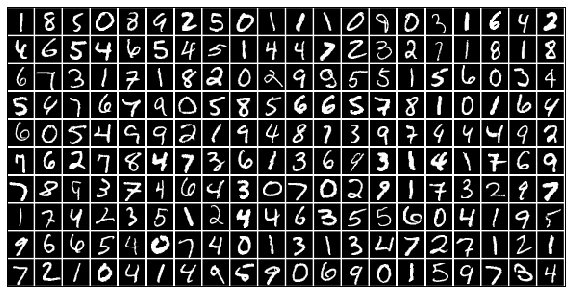

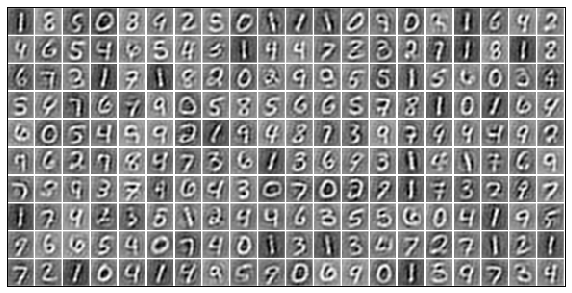

In [18]:
image_data = s.data[probe_FS]
plot_images(test_images[:n_images])
plot_images(np.array(image_data))

Error rate is about 15%. Ideas for improving accuracy: 

<ul>
<li> use more neurons - model has a total of 12500 neurons. </li>
<li> pick better filters - there's data on the parameters of the Gabors in V1 </li>
<li> add another layer higher than V1 simple cells </li>
<li> use higher intercepts to promote sparsity </li>
</ul>